Example notebook for running the scripted ICA.

In [15]:
from astropy.io import fits
import sys
sys.path.append("/Users/Trevor1/Dropbox/ICA_module/code_main/")
#sys.path.append("/Users/Trevor1/Dropbox/ICA_module/")
import run_ICA_r20_components
sys.path.append("/Users/Trevor1/Dropbox/HST/HSTCode/")
import Cut_Edge_Pix_TVM
import Small_Pix_Filter_TVM
import spec_morph
import plot_ICA
import matplotlib.pyplot as plt
import richardsplot as rplot
import numpy as np

/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [16]:
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True

In [13]:
def blueshift(wave_half_flux):
    '''
    compute blueshift given wavelength where half the EW
    of CIV has been accumulated; units Angstroms
    '''
    return ((1549.48 - wave_half_flux) / 1549.48) * 3e5

def get_CIV(wave, flux, wave_r, flux_r, name, ax, EW_region=[1500,1600], cont_region=[[1445,1465],[1700,1705]]):
    #print("Getting CIV")
    #Going to save plots, but not show with magic above
    #"""
    ylow, yup = max(0, np.percentile(flux_r, 1)-np.nanmedian(flux_r)/5), np.percentile(flux_r, 99)+np.nanmedian(flux_r)
    #fig, ax = plt.subplots(figsize=(9,9))
    #fig = plt.figure(figsize=(9,9))
    ax.plot(wave, flux, "-k", alpha=0.5)#, label="HST co-add")
    ax.plot(wave_r, flux_r, "-b", lw=1.8)#, label="ICA fit")
    ax.plot([1549.48,1549.48], [ylow,yup], "--k", label="CIV Rest Wavelength")
    #"""

    #Fit continuum -- ADD MANUAL HERE
    cont1 = ((wave_r>=cont_region[0][0])&(wave_r<=cont_region[0][1]))
    cont2 = ((wave_r>=cont_region[1][0])&(wave_r<=cont_region[1][1]))
    ax.axvspan(cont_region[0][0], cont_region[0][1], alpha=0.5, color='grey')
    ax.axvspan(cont_region[1][0], cont_region[1][1], alpha=0.5, color='grey')

    m,b = np.polyfit(np.concatenate((wave_r[cont1], wave_r[cont2])), np.concatenate((flux_r[cont1], flux_r[cont2])), 1)
    continuum = wave_r*m + b
    ax.plot(wave_r, continuum, "-m")

    #Plot EW region under flux_r -- ADD MANUAL HERE
    EW = ((wave_r>=EW_region[0])&(wave_r<=EW_region[1]))

    #And compute the EW
    CIV_EW = 0
    ew_list = [0.]
    for i in range(len(wave_r[EW])):
        try:
            CIV_EW += max(( (flux_r[EW][i] - continuum[i]) / continuum[i] ) * ( wave_r[EW][i+1] - wave_r[EW][i] ), 0) #no absorption
        except IndexError:
            CIV_EW += max(( (flux_r[EW][i] - continuum[i]) / continuum[i] ) * ( wave_r[EW][i] - wave_r[EW][i-1] ), 0)

        ew_list.append(CIV_EW)

    ax.fill_between(wave_r[EW], continuum[EW], flux_r[EW], color="blue", alpha=0.2, label="Equivalent Width = %.1f Å"%CIV_EW)

    ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()
    CIV_blue = blueshift(wave_r[EW][ind_half_flux])
    #"""
    #for w in np.arange(1450,1530,10): ax.plot([w,w],[ylow,yup],"--",label=str(w))
    #for w in np.arange(1610,1640,10): ax.plot([w,w],[ylow,yup],"--",label=str(w))
    ax.plot([EW_region[0],EW_region[0]], [ylow,yup], "-b", alpha=0.7)
    ax.plot([EW_region[1],EW_region[1]], [ylow,yup], "-b", alpha=0.7)
    ax.plot([wave_r[EW][ind_half_flux],wave_r[EW][ind_half_flux]], [ylow,yup], "--b", label="Blueshift = %.1f km/s" % (CIV_blue))
    ax.set_xlim(1435, 1710)
    ax.set_ylim(ylow, yup)
    ax.set_xlabel("Rest Wavelength (Å)", fontsize=30)
    #ax.set_ylabel("Flux (Arbitrary Units)", fontsize=20)
    #ax.set_title("Blue, EW = %.2f km/s, %.2f Å" % (CIV_blue,CIV_EW), fontsize=20)
    ax.set_title(name, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    ax.tick_params(labelleft=False)
    ax.legend(loc="best", prop={"size":20})
    return CIV_blue, CIV_EW

First test on a $z\sim2$ SDSS quasar.  This is the "base case" that should definitely work!

In [2]:
!ls

example_civ_fromICA.ipynb
icascript_example.ipynb
icascript_f2500_nocoverage_testing.ipynb
icascript_preprocess_example-Copy1.ipynb
icascript_preprocess_example.ipynb
icascript_rebin.ipynb
icascript_rebinTesting.ipynb


<ipython-input-3-c49838529033>:6: RuntimeWarning: divide by zero encountered in divide
  errsSDSS = 1. / np.sqrt(spec[1].data["IVAR"]) * 10**-17


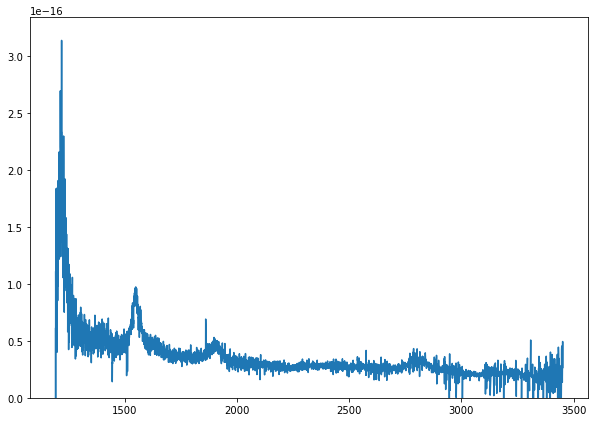

In [3]:
spec = fits.open("../data/spec-6715-56449-0294.fits")
zSDSS = 1.99703

waveSDSS = 10.**spec[1].data["LOGLAM"] / (1+zSDSS)
fluxSDSS = spec[1].data["FLUX"] * 10**-17
errsSDSS = 1. / np.sqrt(spec[1].data["IVAR"]) * 10**-17
maskSDSS = spec[1].data["AND_MASK"]

fig = plt.figure(figsize=(10,7))
plt.plot(waveSDSS, fluxSDSS)
plt.ylim(0,None)
plt.show()

In [4]:
resolution = [3.e5*((waveSDSS[i+1]-waveSDSS[i])/waveSDSS[i]) for i in range(len(waveSDSS)-1)]
round(np.median(resolution)), resolution

(69,
 [69.18277067597955,
  69.01318120071664,
  69.15091071277857,
  69.01212473167107,
  69.02695895405486,
  69.164574961178,
  69.02586319483817,
  69.19409497641027,
  69.0247499733232,
  69.16222628206015,
  69.02362802065909,
  69.00775479152799,
  69.17578139109537,
  69.00661974214017,
  69.20519663253799,
  69.00546723045409,
  69.17332793818787,
  69.00431035319343,
  69.01904853293672,
  69.18677390785888,
  69.01785673107952,
  69.18549916008487,
  69.01665183249861,
  69.1842069500126,
  68.98486608406529,
  69.03012399561703,
  69.16699785506353,
  69.028879806865,
  69.19622101122513,
  68.99708532728255,
  69.1948807798326,
  68.99582804180682,
  69.01047454448417,
  69.17761056683958,
  69.03968460392207,
  69.17623977642506,
  69.00789012433961,
  69.17486025486141,
  69.00658045196906,
  69.02117020217702,
  69.18800936546177,
  69.01982997078449,
  69.15614503668621,
  69.01848100824282,
  69.18515427969396,
  69.01711458340287,
  69.00124135427177,
  69.1981986165

In [ ]:
wave, flux_morph, errs_morph, mask_witer, wave_ica, flux_ica, f2500_ica

In [7]:
wave_arb, flux_arb, errs_arb, mask_arb, wave_ica, flux_ica, f2500_ica = \
run_ICA_r20_components.main_ICA(waveSDSS, fluxSDSS, errsSDSS, 
                                                                          maskSDSS, zSDSS, name="", 
                                        ica_path="/Users/Trevor1/Dropbox/ICA_module/components/")

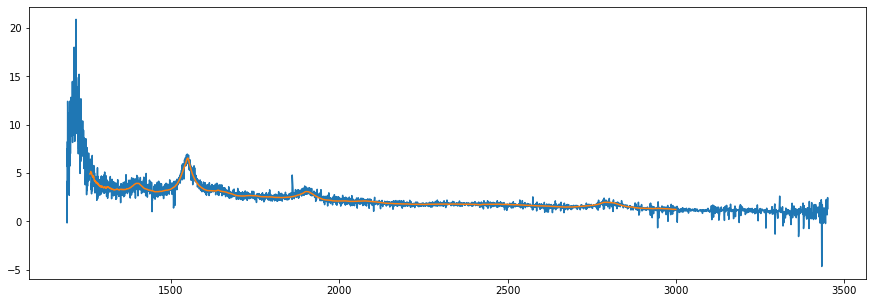

In [9]:
fig = plt.figure(figsize=(15,5))
plt.plot(wave_arb, flux_arb)
plt.plot(wave_ica, flux_ica)
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


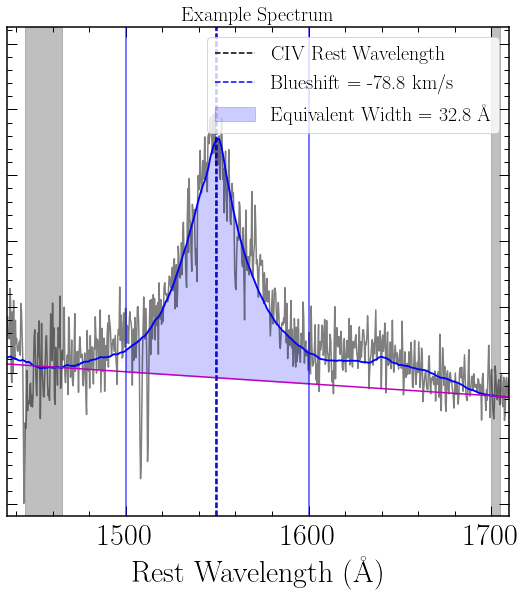

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9,9))
get_CIV(wave_arb, flux_arb, wave_ica, flux_ica, "Example Spectrum", ax=ax)
plt.show()

In [8]:
f2500_ica

2.833025685511766e-17

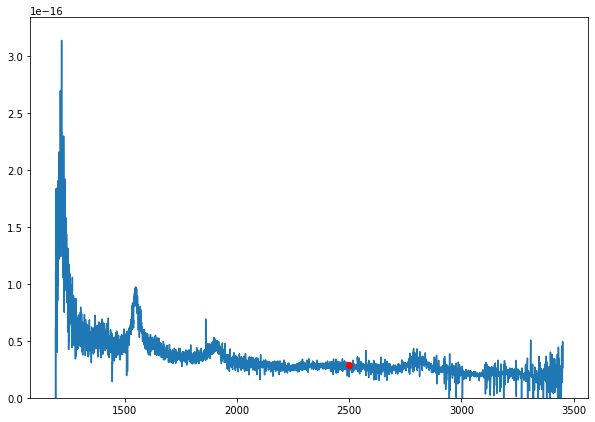

In [8]:
fig = plt.figure(figsize=(10,7))
plt.plot(waveSDSS, fluxSDSS)
plt.scatter(2500, f2500_ica, color="r", zorder=3)
plt.ylim(0,None)
plt.show()